# House prices analysis for Kaggle competition

by
Greg Pelletier

Kaggle has an open competition for advanced regression analysis of house prices. The link describing the kaggle competition is here:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In this notebook I use a variety of Lasso linear regression methods with the lasso function in the stepAIC module that is available at this link:

https://github.com/gjpelletier/stepAIC

### Lasso linear regression using the stepAIC module

The **lasso** function in the stepAIC module provides output of regression models and summary statistics using the following methods:

- LassoCV: Lasso using Cross-Validation with coordinate descent to optimize alpha
- LassoLarsCV: Lasso using Cross-Validation with Least Angle Regression
- LassoLarsIC using AIC: Lasso using Least Angle Regression with Akaike Information Criterion
- LassoLarsIC using BIC: Lasso using Least Angle Regression with Bayesian Information Criterion

Lasso (Least Absolute Shrinkage and Selection Operator) adds a penalty to the loss function. This penalty encourages sparsity in the model, meaning that some coefficients will be exactly zero, effectively removing the corresponding predictors from the model. 

Lasso linear regression includes a penalty term to the standard least squares objective function. The penalty term is a sum of the absolute values of the regression coefficients multiplied by a hyperparameter, denoted as "alpha". The **lasso** function finds the optimum value of alpha for each of the methods listed above. The alpha determines the amount of shrinkage applied to the model coefficients. As alpha increases, the coefficients are pushed towards zero, and some may become exactly zero, effectively eliminating those features from the model. 

Lasso regression is useful for dealing with multicollinearity, where predictors are highly correlated, and when an optimal subset of the candidate features should be included in the model. 

### Kaggle competition leaderboard score using this notebook

The analysis documented in this notebook resulted in a leaderboard score of 0.12561 using the results from LassoCV. Any score between 0.1 to 0.15 is considered to be a "good" score.

## Install the lasso function from stepAIC

In [1]:
# # Run the following commands to install stepAIC for the first time
# !pip install git+https://github.com/gjpelletier/stepAIC.git

# # Run the following commands to upgrade stepAIC to the latest versions
# !pip install git+https://github.com/gjpelletier/stepAIC.git --upgrade

## Import libraries and functions

In [2]:
from stepAIC import lasso
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, gamma, lognorm, skew
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

## Read raw train and test data downloaded from kaggle

The csv files used in this notebook for the training data (train.csv) and testing data (test.csv) are available to download from kaggle at the following link:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [3]:
# read train data into dataframe df_train
train_path = "/mnt/c/z/kaggle/house_prices/data/train.csv"
df_train = pd.read_csv(train_path)
print("Full train dataset shape is {}".format(df_train.shape))
# print(df_train.head())

# read test data into dataframe df_test
test_path = "/mnt/c/z/kaggle/house_prices/data/test.csv"
df_test = pd.read_csv(test_path)
print("Full test dataset shape is {}".format(df_test.shape))
# print(df_test.head())

Full train dataset shape is (1460, 81)
Full test dataset shape is (1459, 80)


## Remove high leverage data points

We will start by plotting the SalePrice vs above ground living area (GrLivArea) to look for data points that have high leverage

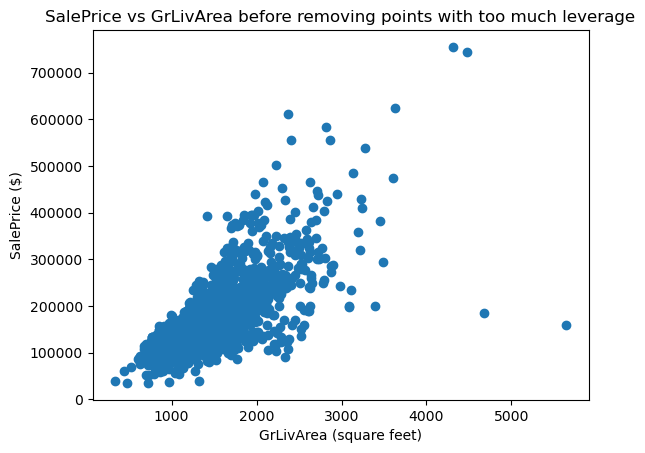

In [4]:
#GrLivArea vs. SalePrice
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.xlabel('GrLivArea (square feet)')
plt.ylabel('SalePrice ($)')
# plt.xscale("log")
# plt.yscale("log")
plt.title('SalePrice vs GrLivArea before removing points with too much leverage');

Data points with GrLivArea > 4000 square feet appear to exert too much leverage. We will remove these data ponts from the training analysis

In [5]:
# remove the high leverage points
df_train = df_train[df_train['GrLivArea'] < 4000]
print("Train dataset with leverage points removed shape is {}".format(df_train.shape))

Train dataset with leverage points removed shape is (1456, 81)


## Combine the train and test data for transformations and pre-processing steps

In [6]:
#Combine Datasets
data = pd.DataFrame()
data = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                      df_test.loc[:,'MSSubClass':'SaleCondition']))
print("Combined train and test dataset shape is {}".format(data.shape))
# print(data.head())

Combined train and test dataset shape is (2915, 79)


## Data cleaning

The following sections on data cleaning, feature transformations and engineering, encoding of categerical features, and standardizing numeric features are adapted from the Jupyter notebook published at the following githup repo:

https://github.com/MerleSt/HousingPricePrediction

In [7]:
data2 = data.copy()

In [8]:
# ensure proper data type
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

In [9]:
# Categorical missing data

# Impute using constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna('None')


# Impute using column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

In [10]:
# Get categorical columns with at least one missing value
data2.select_dtypes('object').loc[:, data2.isna().sum()>0].columns

Index([], dtype='object')

In [11]:
data3 = data2.copy()

## Numeric features

In [12]:
# Numeric features

def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
    ]:
    data3 = knn_impute(data3, column)    

In [13]:
data4=data3.copy()

## Feature engineering

In [14]:
data4["SqFtPerRoom"] = data4["GrLivArea"] / (data4["TotRmsAbvGrd"] +
                                                       data4["FullBath"] +
                                                       data4["HalfBath"] +
                                                       data4["KitchenAbvGr"])

data4['Total_Home_Quality'] = data4['OverallQual'] + data4['OverallCond']

data4['Total_Bathrooms'] = (data4['FullBath'] + (0.5 * data4['HalfBath']) +
                               data4['BsmtFullBath'] + (0.5 * data4['BsmtHalfBath']))

data4["HighQualSF"] = data4["1stFlrSF"] + data4["2ndFlrSF"]

In [15]:
data5 = data4.copy()

## Feature transformations

In [16]:
# Log transform skewed features
skew_df = pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: stats.skew(data5[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,0.983356,0.983356,True
1,LotArea,13.123758,13.123758,True
2,OverallQual,0.181902,0.181902,False
3,OverallCond,0.569143,0.569143,True
4,YearBuilt,-0.598087,0.598087,True
5,YearRemodAdd,-0.449113,0.449113,False
6,MasVnrArea,2.590651,2.590651,True
7,BsmtFinSF1,0.974305,0.974305,True
8,BsmtFinSF2,4.142830,4.142830,True
9,BsmtUnfSF,0.920117,0.920117,True


In [17]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data5[column] = np.log1p(data5[column])

## Cosine transform cyclical month sold

In [18]:
data5['MoSold'] = (-np.cos(0.5236 * data5['MoSold']))   # 2*np.pi/12 = 0.5236

In [19]:
data6 = data5.copy()

## Encode categorical features

In [20]:
data6 = pd.get_dummies(data6)
data7 = data6.copy()
data7

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,1.791759,7.602900,2003,5.283204,6.561031,0.0,5.017280,...,False,False,False,True,False,False,False,False,True,False
1,4.394449,9.169623,6,2.197225,7.589336,1976,0.000000,6.886532,0.0,5.652489,...,False,False,False,True,False,False,False,False,True,False
2,4.234107,9.328212,7,1.791759,7.601902,2002,5.093750,6.188264,0.0,6.075346,...,False,False,False,True,False,False,False,False,True,False
3,4.110874,9.164401,7,1.791759,7.557995,1970,0.000000,5.379897,0.0,6.293419,...,False,False,False,True,True,False,False,False,False,False
4,4.442651,9.565284,8,1.791759,7.601402,2000,5.860786,6.486161,0.0,6.196444,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,3.091042,7.568896,4,2.079442,7.586296,1970,0.000000,0.000000,0.0,6.304449,...,False,False,False,True,False,False,False,False,True,False
1455,3.091042,7.546974,4,1.791759,7.586296,1970,0.000000,5.533389,0.0,5.686975,...,False,False,False,True,True,False,False,False,False,False
1456,5.081404,9.903538,5,2.079442,7.581210,1996,0.000000,7.110696,0.0,0.000000,...,False,False,False,True,True,False,False,False,False,False
1457,4.143135,9.253591,5,1.791759,7.597396,1992,0.000000,5.823046,0.0,6.356108,...,False,False,False,True,False,False,False,False,True,False


## Standardize numeric features

In [21]:
scaler = StandardScaler()
scaler.fit(data7)

data7 = pd.DataFrame(scaler.transform(data7), index=data7.index, columns=data7.columns)

In [22]:
data8 = data7.copy()

## Check normality of SalePrice 

The following analysis shows that SalePrice appears to be log-normal

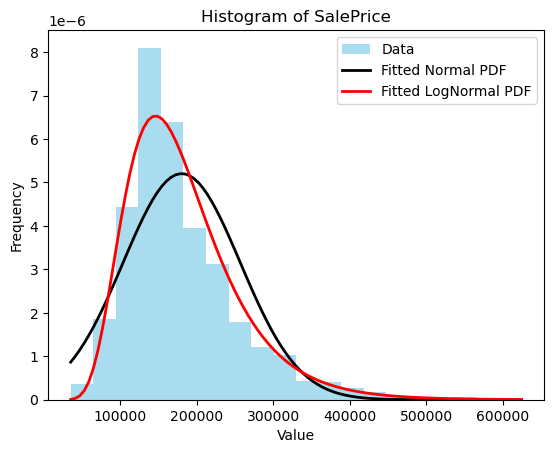

In [23]:
# Plot SalePrice normal and lognormal pdf
df_y = df_train['SalePrice']
plt.figure()
column_data = df_y
plt.hist(column_data, bins=20, density=True, alpha=0.7, color='skyblue', label='Data')
x = np.linspace(min(column_data), max(column_data), 100)
# Paameters for the normal distribution
mean, stdev = norm.fit(column_data)
pdf_norm = norm.pdf(x, mean, stdev)
plt.plot(x, pdf_norm, 'k', linewidth=2, label='Fitted Normal PDF')
# Parameters for the log-normal distribution
shape,loc,scale = lognorm.fit(column_data)
pdf_lognorm = lognorm.pdf(x, s=shape, scale=scale)
plt.plot(x, pdf_lognorm, 'r', linewidth=2, label='Fitted LogNormal PDF')
plt.legend()
plt.title(f'Histogram of SalePrice')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

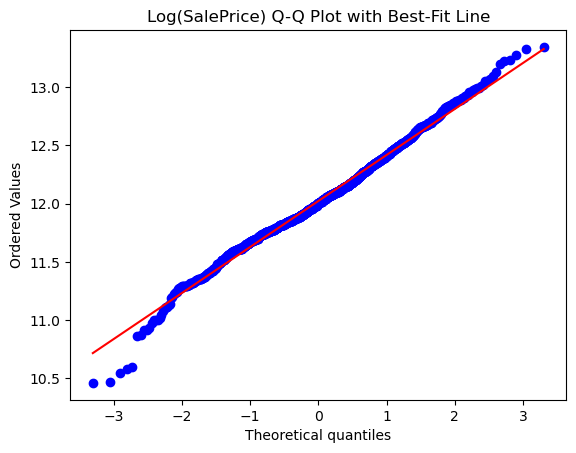

In [24]:
# QQ plot of SalePrice
fig, ax = plt.subplots();
stats.probplot(np.log(df_train['SalePrice']), dist="norm", plot=ax);
ax.set_title("Log(SalePrice) Q-Q Plot with Best-Fit Line");

## Define the response variable of train as y_train = log(SalePrice)

In [25]:
y_train = np.log(df_train['SalePrice'])
print('y_train shape: ',y_train.shape)

y_train shape:  (1456,)


## Split the combined data back into train and test data sets

In [26]:
#Split the data back into the training and test sets
X_train = data8[:df_train.shape[0]]
X_test = data8[df_train.shape[0]:]

print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)

X_train shape:  (1456, 319)
X_test shape:  (1459, 319)


## Lasso linear regression

Next we will use the **lasso** function from the stepAIC module (https://github.com/gjpelletier/stepAIC). We will use the the following optional arguments for **lasso**:

- n_alpha=100 (number of log-spaced alpha values to evaluate)
- alpha_min = 1e-5 (low end of the log-spaced alpha values to evalauate)
- alpha_max = 1 (high end of the log-spaced alpha values to evalauate)
- standardize='off' (this is because we have already standardized the features and do not want the lasso function to standardize them again)

Note that this notebook takes about 4 minutes to perform the lasso analysis in the next code cell usng n_alpha=100. For the competition entry I used n_alpha=1000 with alpha_min=1e-5 and alpha_max=10, which took about 23 minutes to process on my laptop

Fitting Lasso regression models, please wait ...


Lasso regression statistics of best models in model_outputs['stats']:


| Statistic          |         LassoCV |     LassoLarsCV |    LassoLarsAIC |    LassoLarsBIC |
|:-------------------|----------------:|----------------:|----------------:|----------------:|
| alpha              |     0.00339386  |     0.00623391  |     0.00458965  |     0.0103353   |
| r-squared          |     0.938103    |     0.926542    |     0.928721    |     0.919877    |
| adjusted r-squared |     0.932841    |     0.922437    |     0.923798    |     0.917202    |
| nobs               |  1456           |  1456           |  1456           |  1456           |
| df residuals       |  1342           |  1379           |  1362           |  1409           |
| df model           |   113           |    76           |    93           |    46           |
| F-statistic        |   179.992       |   228.862       |   190.817       |   351.66        |
| Prob (F-statistic) |

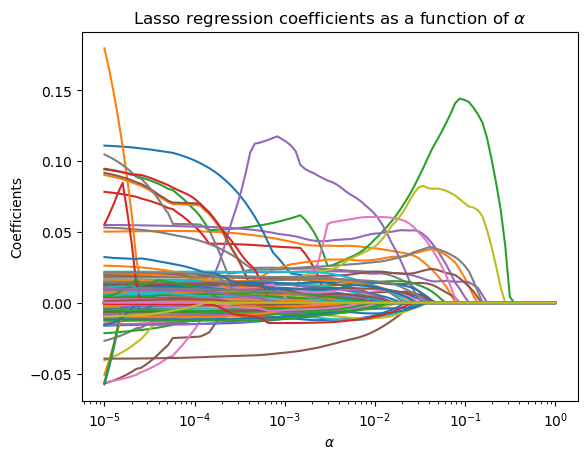

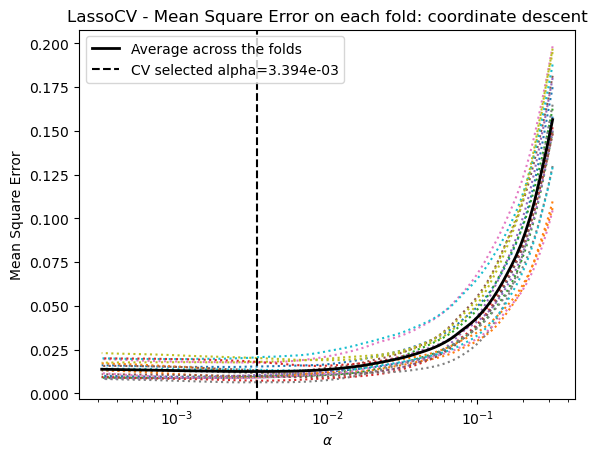

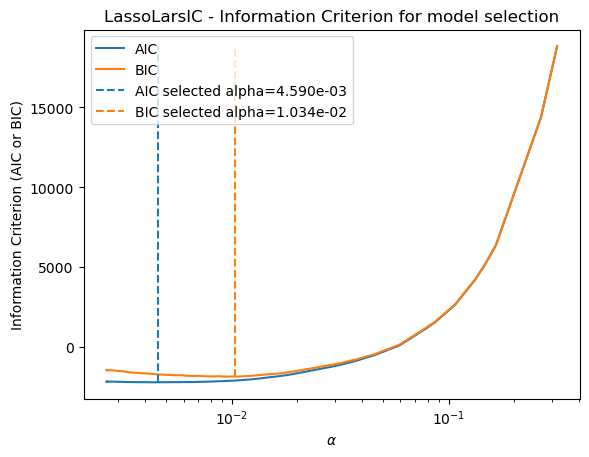

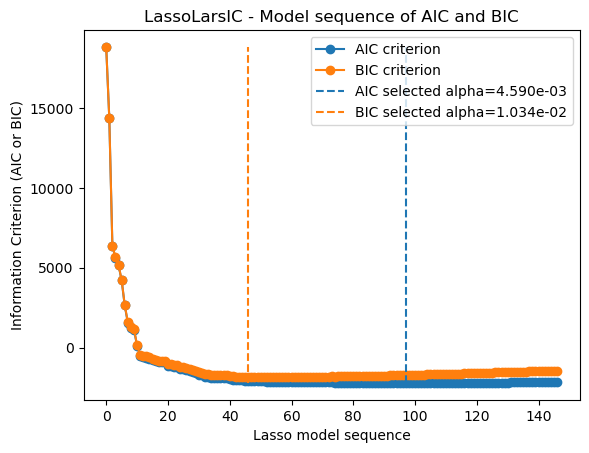

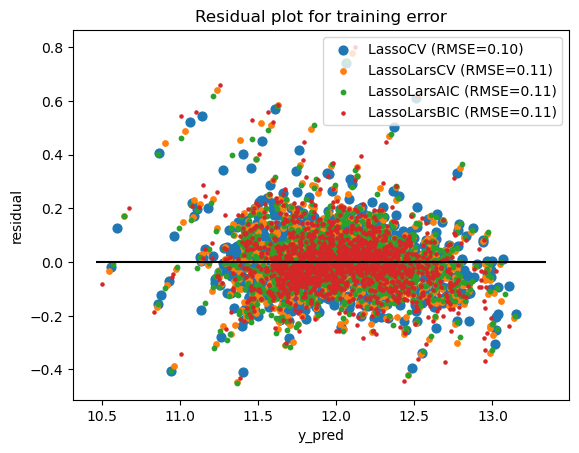

In [27]:
from stepAIC import lasso
model_object, model_output = lasso(X_train, y_train, standardize='off', alpha_min=1e-5, alpha_max=1, n_alpha=100)

## Display summary statistics of regression results 

The following cell displays the regression statistics for the results using LassoCV, LassoLarsCV, and LassoLarsIC using AIC and BIC as the criterion.

In [28]:
print(model_output['stats'])

                         LassoCV   LassoLarsCV  LassoLarsAIC  LassoLarsBIC
Statistic                                                                 
alpha               3.393858e-03  6.233905e-03  4.589654e-03  1.033529e-02
r-squared           9.381029e-01  9.265415e-01  9.287210e-01  9.198766e-01
adjusted r-squared  9.328409e-01  9.224368e-01  9.237980e-01  9.172020e-01
nobs                1.456000e+03  1.456000e+03  1.456000e+03  1.456000e+03
df residuals        1.342000e+03  1.379000e+03  1.362000e+03  1.409000e+03
df model            1.130000e+02  7.600000e+01  9.300000e+01  4.600000e+01
F-statistic         1.799923e+02  2.288619e+02  1.908173e+02  3.516602e+02
Prob (F-statistic)  1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16
RMSE                9.850740e-02  1.073135e-01  1.057096e-01  1.120762e-01
Log-Likelihood      1.308485e+03  1.183818e+03  1.205745e+03  1.120593e+03
AIC                -2.388971e+03 -2.213636e+03 -2.215903e+03 -2.107708e+03
BIC                -1.786

## Save the results as the submission.csv

Note that the RMSE of the training data does not necessarily indicate the best score with the test data, although in this case it does. I submitted the resuts using LassoCV, LassoLarsCV, LassoLarsAIC, and LassoLarsBIC. The test predictions using LassoCV resulted in my best score on kaggle with official kaggle leaderboard score of 0.12561 and rank of 753

In [340]:
model = model_object['LassoCV']

# Make predictions
y_pred = model.predict(X_test)
SalePrice = np.exp(y_pred)

result = pd.DataFrame([df_test['Id'],SalePrice]).T
result.rename(columns={'Unnamed 0': 'SalePrice'}, inplace=True)
result['Id'] = result['Id'].astype(int)
result.to_csv('submission_LassoCV_v11.csv', index=False)

print("Predicted SalePrice for test data set: \n", result)

Predicted SalePrice for test data set: 
         Id      SalePrice
0     1461  122648.472186
1     1462  154100.680580
2     1463  181578.271355
3     1464  196345.286070
4     1465  201835.480020
...    ...            ...
1454  2915   89014.749378
1455  2916   84446.498527
1456  2917  162069.337285
1457  2918  122512.300610
1458  2919  219398.827893

[1459 rows x 2 columns]


## Check the QQ plot of log(SalePrice) comparing training data with predicted test data

The log-normal distributions of observed SalePrice in the train data set and predicted SalePrice in the test dataset look very similar 

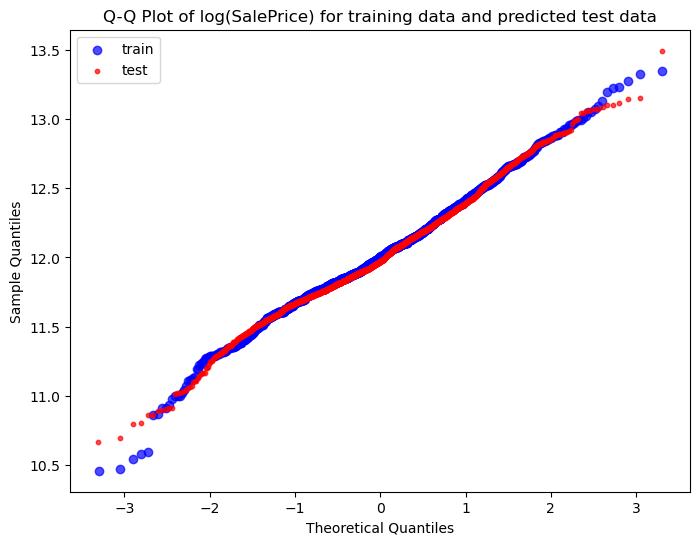

In [341]:
# QQ plot of training data and predicted SalePrice

# assign data1=train and data2=test
# data1 = np.log(df_train_num['SalePrice'])
# data2 = np.log(result['SalePrice'])
data1 = y_train
data2 = np.log(result['SalePrice'])

# Generate Q-Q plot data for both datasets
qq1 = stats.probplot(data1, dist="norm")
qq2 = stats.probplot(data2, dist="norm")

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the first dataset
plt.scatter(qq1[0][0], qq1[0][1], color='blue', label='train', alpha=0.7)

# Plot the second dataset
plt.scatter(qq2[0][0], qq2[0][1], color='red', label='test', alpha=0.7, s=10)

# Customize the plot
plt.title('Q-Q Plot of log(SalePrice) for training data and predicted test data')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
# plt.grid()

# Show the plot
plt.show()


## User help for the lasso function of stepAIC

In [345]:
help(lasso)

Help on function lasso in module stepAIC:

lasso(X, y, **kwargs)
    Python function for Lasso linear regression
    using k-fold cross-validation (CV) or to minimize AIC or BIC

    by
    Greg Pelletier
    gjpelletier@gmail.com
    17-May-2025

    REQUIRED INPUTS (X and y should have same number of rows and
    only contain real numbers)
    X = dataframe of the candidate independent variables
        (as many columns of data as needed)
    y = dataframe of the dependent variable (one column of data)

    OPTIONAL KEYWORD ARGUMENTS
    **kwargs (optional keyword arguments):
        nfolds= number of folds to use for cross-validation (CV)
            with k-fold LassoCV or LassoLarsCV (default nfolds=20)
        standardize= 'on' (default) or 'off' where
            'on': standardize X using sklearn.preprocessing StandardScaler
            'off': do not standardize X
        alpha_min= minimum value of range of alphas to evaluate (default=1e-3)
        alpha_max= maximum value of ra